# **Project on Time Series**
+ create a short-term temperature forecast for Berlin.
+ Use of Temperature Date from 1948 to 2021 (taken from from www.ecad.eu)
+ as a final bonus the temperature data within the timeframe (1948-2021) will be illustrated with the geopanda and folium packages. A map of Germany will be generated with the mean temperature of the year. in a next step a Gif will be created which shows the progression of the mean temperature over the timespan


---

## **0. Imports**

In [245]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

#machine learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Set the figure size 
plt.rcParams['figure.figsize'] = (15,5)
sns.set()

from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.datasets import load_wineind

import statsmodels
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from cleanup import clean_data
#from engineer import feature_engineer

import folium
import io
from PIL import Image
import time
from selenium import webdriver
import imageio

---
---

## **1. Business goal**
+ Analyzing the Temperatur data for Berlin and run a forecast

---
---

## **2. Get Data**

### **2.1 Load and prepare the data**
+ set the datatype of the dates to 'datetime'
+ rename columns
+ drop unneccesary columns

In [2]:
df = pd.read_csv('Data/Temperatures.txt')

In [3]:
df.columns= ['Soid', 'Date', 'Temperature in °C','Value Status']

In [4]:
#transform datetime 
df['Date'] =  pd.to_datetime(df['Date'],format='%Y%m%d')
df['Temperature in °C']= df['Temperature in °C']*0.1
df = df.drop(['Soid'], axis = 1)

In [5]:
df.head()

,Date,Temperature in °C,Value Status
0,1876-01-01,2.2,0
1,1876-01-02,2.5,0
2,1876-01-03,0.3,0
3,1876-01-04,-5.8,0
4,1876-01-05,-9.8,0


---

### **2.2 Analyze data structure and descriptive statistics**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53112 entries, 0 to 53111
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               53112 non-null  datetime64[ns]
 1   Temperature in °C  53112 non-null  float64       
 2   Value Status       53112 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [7]:
df.describe()

,Temperature in °C,Value Status
count,53112.000000,53112.000000
mean,5.673273,0.033062
std,61.547333,0.544354
min,-999.900000,0.000000
25%,3.300000,0.000000
50%,9.300000,0.000000
75%,15.700000,0.000000
max,30.500000,9.000000


---

### **2.3 Analyse the 'Value Status' column**
+ Where are the missing values?
+ Where are the suspected values?

In [8]:
# "9" equals missing data and "1" represents suspected values. 
df['Value Status'].unique()

array([0, 9, 1])

In [9]:
# supected entires
df.loc[df['Value Status'] == 1].tail()

,Date,Temperature in °C,Value Status
25952,1947-01-21,-2.7,1


In [10]:
# missing entries
df.loc[df['Value Status'] == 9].tail()

,Date,Temperature in °C,Value Status
25506,1945-11-01,-999.9,9
25507,1945-11-02,-999.9,9
25508,1945-11-03,-999.9,9
25509,1945-11-04,-999.9,9
25510,1945-11-05,-999.9,9


---
---

### **2.4 Clean Data** 
+ Generate a dataframe from 1948 to 2021 since all missing or suspected values are within 1945 and 1948
+ Set index to 'Date'
+ Drop the obsolete column 'Value Status'

In [11]:
df_clean = df[(df['Date'] >= '1948-01-01')]
#Set the date as an index
df_clean.set_index('Date', inplace=True)
df_clean = df_clean.drop(['Value Status'], axis = 1)

In [12]:
df_clean.tail()

,Temperature in °C
Date,
2021-05-27,11.8
2021-05-28,11.6
2021-05-29,12.5
2021-05-30,13.9
2021-05-31,14.7


In [13]:
df_clean.describe()

,Temperature in °C
count,26815.000000
mean,9.839881
std,7.879026
min,-18.500000
25%,3.800000
50%,10.000000
75%,16.100000
max,30.500000


---
---

## **3. Visualize Data**

### **3.1 Inspect the temperatures beginning 1948**

In [14]:
# Plot the data
def plot_temp(df, title='Temperature over time'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature in °C')
    plt.ylim([df_clean['Temperature in °C'].min()*1.1,df_clean['Temperature in °C'].max()*1.2])
    plt.show()

(-20.35, 36.6)

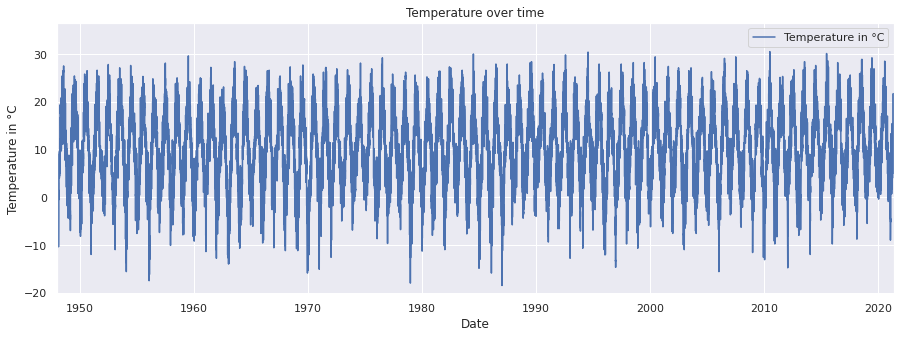

In [15]:
df_clean[['Temperature in °C']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_clean['Temperature in °C'].min()*1.1,df_clean['Temperature in °C'].max()*1.2])

---

### **3.2 Inspect the temperatures beginning 2000**

(10957.0, 18778.0)

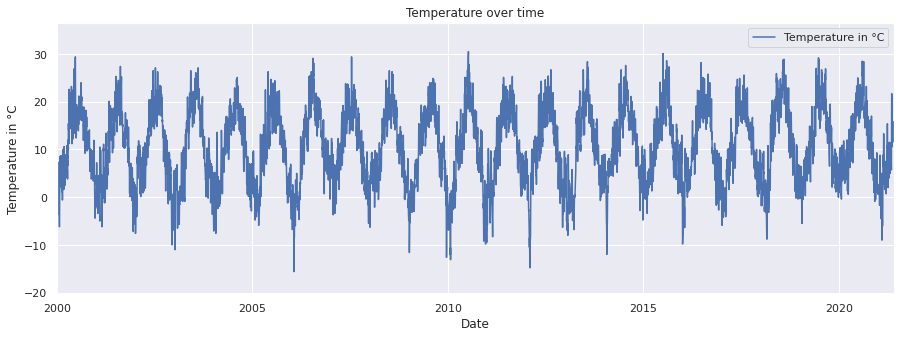

In [16]:
df_clean[['Temperature in °C']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_clean['Temperature in °C'].min()*1.1,df_clean['Temperature in °C'].max()*1.2])
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2021-05-31'))

---
---

## **4. Feature Engineering**

In [17]:
df_clean['year'] = df_clean.index.year

In [18]:
df_clean['month'] = df_clean.index.month

In [19]:
df_clean['timestep'] = list(range(len(df_clean)))

In [20]:
seasonal_dummies = pd.get_dummies(df_clean.index.month,prefix='Month',drop_first=True).set_index(df_clean.index)

In [21]:
df_clean = df_clean.join(seasonal_dummies)
df_clean.head()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,
1948-01-01,-1.8,1948,1,0,0,0,0,0,0,0,0,0,0,0,0
1948-01-02,4.4,1948,1,1,0,0,0,0,0,0,0,0,0,0,0
1948-01-03,8.5,1948,1,2,0,0,0,0,0,0,0,0,0,0,0
1948-01-04,10.2,1948,1,3,0,0,0,0,0,0,0,0,0,0,0
1948-01-05,10.5,1948,1,4,0,0,0,0,0,0,0,0,0,0,0


---
---

## **5. Train-Test Split and model training**

### **5.1 Train-Test Split**

In [22]:
df_train = df_clean[:-365]
df_test = df_clean[-365:]

In [23]:
df_train

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,
1948-01-01,-1.8,1948,1,0,0,0,0,0,0,0,0,0,0,0,0
1948-01-02,4.4,1948,1,1,0,0,0,0,0,0,0,0,0,0,0
1948-01-03,8.5,1948,1,2,0,0,0,0,0,0,0,0,0,0,0
1948-01-04,10.2,1948,1,3,0,0,0,0,0,0,0,0,0,0,0
1948-01-05,10.5,1948,1,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,16.4,2020,5,26445,0,0,0,1,0,0,0,0,0,0,0
2020-05-28,14.9,2020,5,26446,0,0,0,1,0,0,0,0,0,0,0
2020-05-29,14.6,2020,5,26447,0,0,0,1,0,0,0,0,0,0,0


---

### **5.2 Modelling the 'Trend' of our data**

In [24]:
# define X and y
X = df_train[['timestep']]
y = df_train['Temperature in °C']

# instantiate the linear model 
m_trend = LinearRegression()

# fit the model 
m_trend.fit(X,y)

LinearRegression()

In [25]:
df_train['trend'] = m_trend.predict(X)

(-20.35, 36.6)

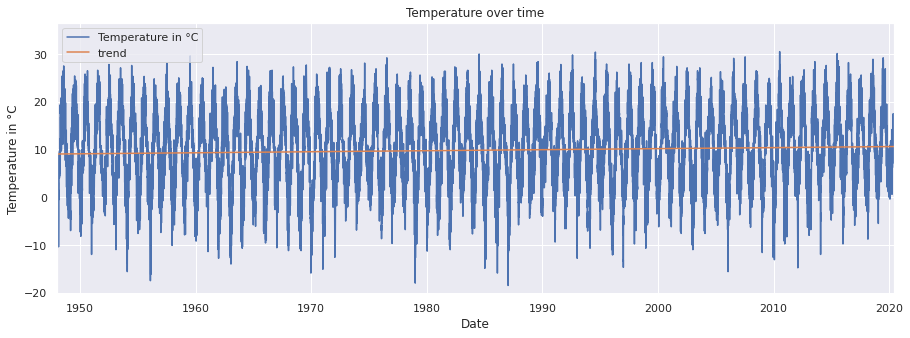

In [26]:
# plot
df_train[['Temperature in °C', 'trend']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_train['Temperature in °C'].min()*1.1,df_train['Temperature in °C'].max()*1.2])

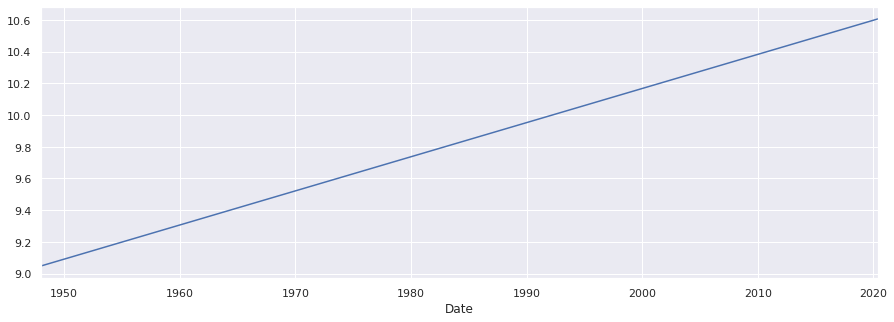

In [27]:
df_train['trend'].plot()
plt.rcParams['figure.figsize'] = (20,5)

In [28]:
df_train['trend'].min(), df_train['trend'].max() 

(9.048057577377266, 10.607624842282469)

---
---

### **5.1 Modelling the 'seasonality' of our data**
#### 5.1.1 First attempt with linear regression

In [29]:
# Define X and y drop unnecessary columns
X = df_train.drop(columns=['Temperature in °C','year','month','trend'])
y  = df_train['Temperature in °C']
# instantiate the linear model 
m = LinearRegression()

# fit the model 
m.fit(X,y)

LinearRegression()

In [30]:
X.head()

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,
1948-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1948-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1948-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1948-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1948-01-05,4,0,0,0,0,0,0,0,0,0,0,0


In [31]:
m.score(X, y)

0.7506655400961887

In [32]:
df_train['trend_seasonal'] = m.predict(X)
df_train.tail()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,trend_seasonal
Date,,,,,,,,,,,,,,,,,
2020-05-27,16.4,2020,5,26445,0,0,0,1,0,0,0,0,0,0,0,10.607389,15.077902
2020-05-28,14.9,2020,5,26446,0,0,0,1,0,0,0,0,0,0,0,10.607448,15.077963
2020-05-29,14.6,2020,5,26447,0,0,0,1,0,0,0,0,0,0,0,10.607507,15.078025
2020-05-30,13.8,2020,5,26448,0,0,0,1,0,0,0,0,0,0,0,10.607566,15.078086
2020-05-31,15.7,2020,5,26449,0,0,0,1,0,0,0,0,0,0,0,10.607625,15.078147


(17897.0, 18413.0)

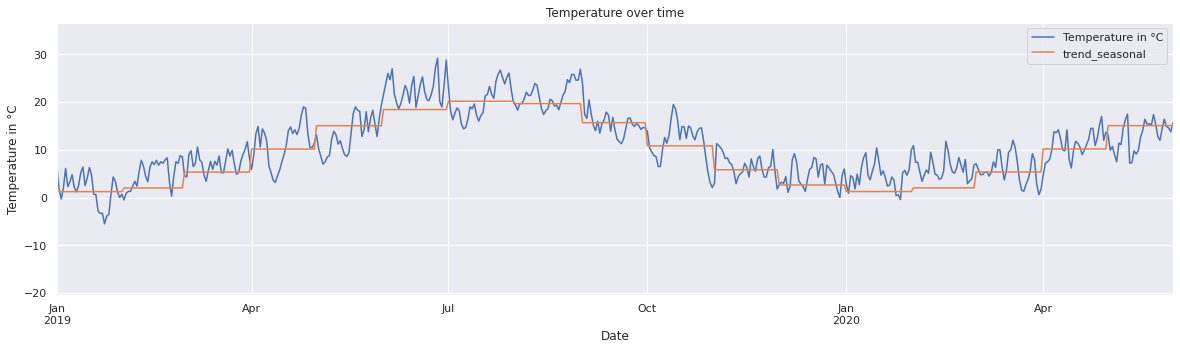

In [33]:
# plot
df_train[['Temperature in °C', 'trend_seasonal']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_train['Temperature in °C'].min()*1.1,df_train['Temperature in °C'].max()*1.2])
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-05-31'))

---

#### 5.1.2 Plot the remainder

In [34]:
# remainder
df_train['remainder'] = df_train['Temperature in °C'] - df_train['trend_seasonal']
df_train['remainder'].to_csv('./Data/remainder.csv')

In [35]:
df_train.describe()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,trend_seasonal,remainder
count,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,26450.000000,2.645000e+04
mean,9.827841,1983.708733,6.502722,13224.500000,0.077996,0.085558,0.082798,0.085558,0.081664,0.084386,0.084386,0.081664,0.084386,0.081664,0.084386,9.827841,9.827841,1.316317e-16
std,7.879197,20.906081,3.450784,7635.601646,0.268171,0.279715,0.275581,0.279715,0.273857,0.277971,0.277971,0.273857,0.277971,0.273857,0.277971,0.450234,6.826612,3.934351e+00
min,-18.500000,1948.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.048058,-0.345182,-1.972524e+01
25%,3.800000,1966.000000,4.000000,6612.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.437949,3.776077,-2.641522e+00
50%,10.000000,1984.000000,7.000000,13224.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.827841,9.732895,-3.676011e-02
75%,16.100000,2002.000000,10.000000,19836.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.217733,16.857887,2.701489e+00
max,30.500000,2020.000000,12.000000,26449.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.607625,20.181847,1.478037e+01


(10957.0, 18413.0)

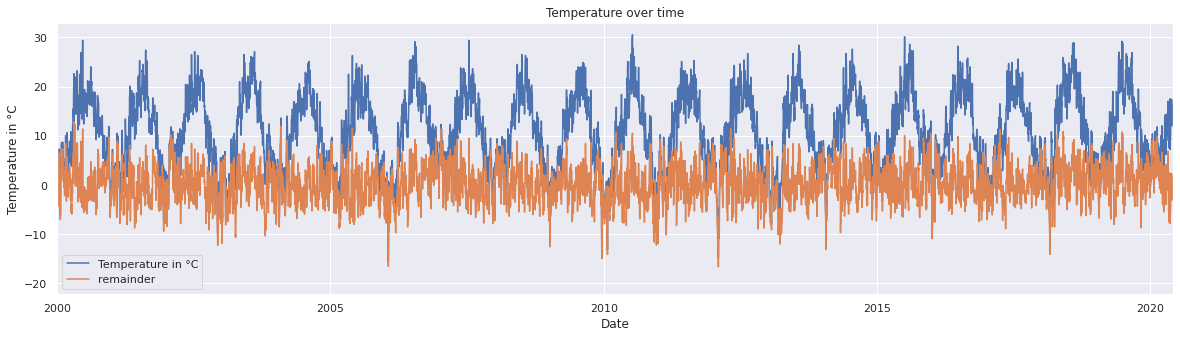

In [36]:
# plot
df_train[['Temperature in °C','remainder']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2020-05-31'))

In [37]:
df_train['remainder'].mean(), df_train['remainder'].std(), df_train['Temperature in °C'].mean(), df_train['Temperature in °C'].std()

(1.3163173554723973e-16,
 3.9343511970867877,
 9.827841209829856,
 7.8791972269211135)

Observation: Remainder is still high. Adding polynominal features might reduce the significance of the remainder (std ~ 4, Regression Score ~0.75) 

---
---

## **6. Model time dependence of the remainder using an AR model**

### **6.1 Create a Dataframe with the remainder and plot the correlation of the remainder with the lag (3 steps)**

In [38]:
df_train.head()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,trend_seasonal,remainder
Date,,,,,,,,,,,,,,,,,,
1948-01-01,-1.8,1948,1,0,0,0,0,0,0,0,0,0,0,0,0,9.048058,-0.345182,-1.454818
1948-01-02,4.4,1948,1,1,0,0,0,0,0,0,0,0,0,0,0,9.048117,-0.345121,4.745121
1948-01-03,8.5,1948,1,2,0,0,0,0,0,0,0,0,0,0,0,9.048176,-0.345059,8.845059
1948-01-04,10.2,1948,1,3,0,0,0,0,0,0,0,0,0,0,0,9.048234,-0.344998,10.544998
1948-01-05,10.5,1948,1,4,0,0,0,0,0,0,0,0,0,0,0,9.048293,-0.344937,10.844937


In [39]:
# Import the remainder 
df_rem = pd.DataFrame(df_train['remainder'])
df_rem.head()

,remainder
Date,
1948-01-01,-1.454818
1948-01-02,4.745121
1948-01-03,8.845059
1948-01-04,10.544998
1948-01-05,10.844937


In [40]:
# Create a time-lagged input feature
df_rem['lag1'] = df_rem['remainder'].shift(1)
df_rem['lag2'] = df_rem['remainder'].shift(2)
df_rem['lag3'] = df_rem['remainder'].shift(3)

<AxesSubplot:>

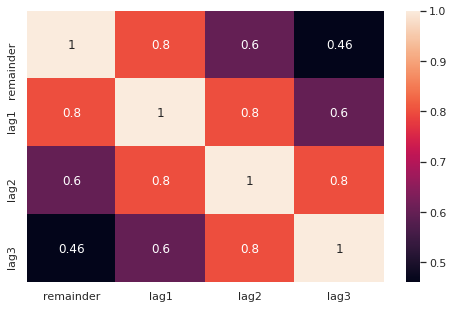

In [42]:
# inspect correlation
plt.rcParams['figure.figsize'] = (8,5)
sns.heatmap(round(df_rem[['remainder','lag1','lag2','lag3']].corr(), 2), annot=True)

---

### **6.2 Setting up the Autoregression**

In [43]:
# Drop missing values
df_rem.dropna(inplace=True)
df_rem.head()

,remainder,lag1,lag2,lag3
Date,,,,
1948-01-04,10.544998,8.845059,4.745121,-1.454818
1948-01-05,10.844937,10.544998,8.845059,4.745121
1948-01-06,3.644876,10.844937,10.544998,8.845059
1948-01-07,3.244815,3.644876,10.844937,10.544998
1948-01-08,6.544754,3.244815,3.644876,10.844937


In [44]:
# Assign X and y
X = df_rem[['lag1']]
y = df_rem['remainder']

In [45]:
# Create and fit the model
m_rem = LinearRegression()
m_rem.fit(X, y)

LinearRegression()

In [46]:
# Create predictions
df_rem['predictions_ar1'] = m_rem.predict(X)
df_rem.head()

,remainder,lag1,lag2,lag3,predictions_ar1
Date,,,,,
1948-01-04,10.544998,8.845059,4.745121,-1.454818,7.108673
1948-01-05,10.844937,10.544998,8.845059,4.745121,8.474960
1948-01-06,3.644876,10.844937,10.544998,8.845059,8.716028
1948-01-07,3.244815,3.644876,10.844937,10.544998,2.929145
1948-01-08,6.544754,3.244815,3.644876,10.844937,2.607605


(18048.0, 18413.0)

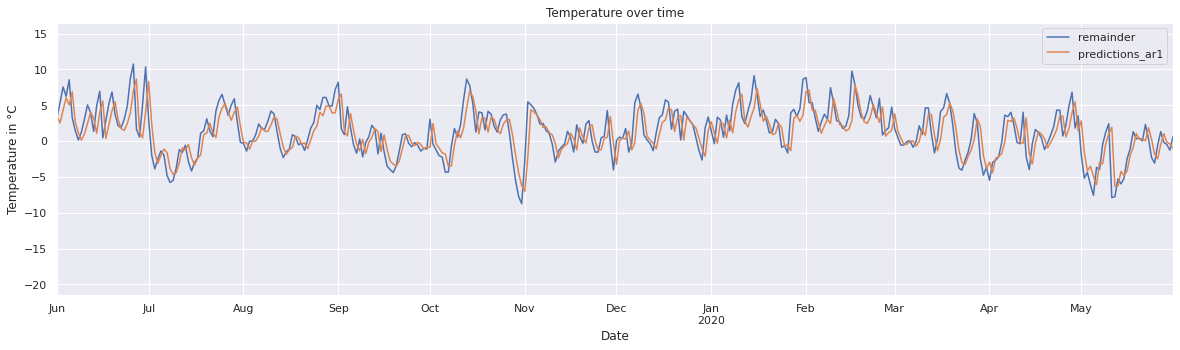

In [47]:
# Plot the original remainder and the prediction
plt.rcParams['figure.figsize'] = (20,5)
df_rem[['remainder', 'predictions_ar1']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.xlim(pd.Timestamp('2019-06-01'), pd.Timestamp('2020-05-31'))

---

#### 6.2.1 How many lags should we include in our Autoregression model?
+ For this we use the 'partial autocorrelation' between different lags

Text(0.5, 0, 'lags')

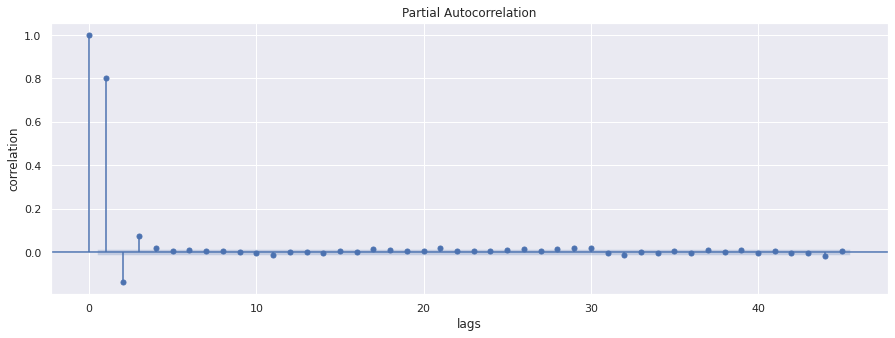

In [48]:
# Statsmodels provides a function called plot_pacf
# plot partial autocorrelation function
plt.rcParams['figure.figsize'] = (15,5)
plot_pacf(df_rem['remainder'])
plt.ylabel('correlation')
plt.xlabel('lags')

#### Observation: A relatively fast decay in correlation suggests, that the remainder is weakly stationary

In [49]:
selected_order = ar_select_order(df_rem['remainder'], maxlag = 12)

/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [50]:
selected_order.ar_lags

array([1, 2, 3])

### **Box-Jenkins-Methodology:**
### Observation: we should use three lag as additional features. 

---
---

## **7. Adding the "lag1-3" as features in our model**

In [51]:
df_train.head()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,trend_seasonal,remainder
Date,,,,,,,,,,,,,,,,,,
1948-01-01,-1.8,1948,1,0,0,0,0,0,0,0,0,0,0,0,0,9.048058,-0.345182,-1.454818
1948-01-02,4.4,1948,1,1,0,0,0,0,0,0,0,0,0,0,0,9.048117,-0.345121,4.745121
1948-01-03,8.5,1948,1,2,0,0,0,0,0,0,0,0,0,0,0,9.048176,-0.345059,8.845059
1948-01-04,10.2,1948,1,3,0,0,0,0,0,0,0,0,0,0,0,9.048234,-0.344998,10.544998
1948-01-05,10.5,1948,1,4,0,0,0,0,0,0,0,0,0,0,0,9.048293,-0.344937,10.844937


In [52]:
df_train_lag = df_train
df_train_lag['lag1'] = df_train_lag['remainder'].shift(1)
df_train_lag['lag2'] = df_train_lag['remainder'].shift(2)
df_train_lag['lag3'] = df_train_lag['remainder'].shift(3)
df_train_lag.dropna(inplace=True)
df_train_lag.describe()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_9,Month_10,Month_11,Month_12,trend,trend_seasonal,remainder,lag1,lag2,lag3
count,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,...,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000,26447.000000
mean,9.828536,1983.712784,6.503346,13226.000000,0.078005,0.085567,0.082807,0.085567,0.081673,0.084395,...,0.081673,0.084395,0.081673,0.084395,9.827930,9.828995,-0.000459,-0.000148,0.000080,0.000043
std,7.879245,20.903807,3.450482,7634.735621,0.268185,0.279729,0.275596,0.279729,0.273871,0.277985,...,0.273871,0.277985,0.273871,0.277985,0.450183,6.826139,3.934080,3.934454,3.934554,3.934564
min,-18.500000,1948.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.048234,-0.344998,-19.725244,-19.725244,-19.725244,-19.725244
25%,3.800000,1966.000000,4.000000,6614.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.438082,3.776215,-2.641671,-2.641671,-2.641671,-2.641671
50%,10.000000,1984.000000,7.000000,13226.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.827930,9.732987,-0.036944,-0.036944,-0.036576,-0.036576
75%,16.100000,2002.000000,10.000000,19837.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,10.217777,16.857932,2.700325,2.701284,2.701766,2.701766
max,30.500000,2020.000000,12.000000,26449.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,10.607625,20.181847,14.780371,14.780371,14.780371,14.780371


In [53]:
# define X and y
X_full = df_train_lag.drop(columns=['Temperature in °C','year','month','trend','remainder' ,'trend_seasonal'])
y_full = df_train_lag['Temperature in °C']

# instantiate the linear model 
m_lag = LinearRegression()

# fit the model 
m_lag.fit(X_full,y_full)

LinearRegression()

In [54]:
X_full.head()

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
1948-01-04,3,0,0,0,0,0,0,0,0,0,0,0,8.845059,4.745121,-1.454818
1948-01-05,4,0,0,0,0,0,0,0,0,0,0,0,10.544998,8.845059,4.745121
1948-01-06,5,0,0,0,0,0,0,0,0,0,0,0,10.844937,10.544998,8.845059
1948-01-07,6,0,0,0,0,0,0,0,0,0,0,0,3.644876,10.844937,10.544998
1948-01-08,7,0,0,0,0,0,0,0,0,0,0,0,3.244815,3.644876,10.844937


In [55]:
m_lag.score(X_full, y_full)

0.9139277376313643

In [56]:
df_train_lag['trend_seasonal_lag1-3'] = m_lag.predict(X_full)
df_train_lag.head()

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_10,Month_11,Month_12,trend,trend_seasonal,remainder,lag1,lag2,lag3,trend_seasonal_lag1-3
Date,,,,,,,,,,,,,,,,,,,,,
1948-01-04,10.2,1948,1,3,0,0,0,0,0,0,...,0,0,0,9.048234,-0.344998,10.544998,8.845059,4.745121,-1.454818,6.772713
1948-01-05,10.5,1948,1,4,0,0,0,0,0,0,...,0,0,0,9.048293,-0.344937,10.844937,10.544998,8.845059,4.745121,7.963855
1948-01-06,3.3,1948,1,5,0,0,0,0,0,0,...,0,0,0,9.048352,-0.344876,3.644876,10.844937,10.544998,8.845059,8.197194
1948-01-07,2.9,1948,1,6,0,0,0,0,0,0,...,0,0,0,9.048411,-0.344815,3.244815,3.644876,10.844937,10.544998,1.607291
1948-01-08,6.2,1948,1,7,0,0,0,0,0,0,...,0,0,0,9.048470,-0.344754,6.544754,3.244815,3.644876,10.844937,2.736647


(17897.0, 18413.0)

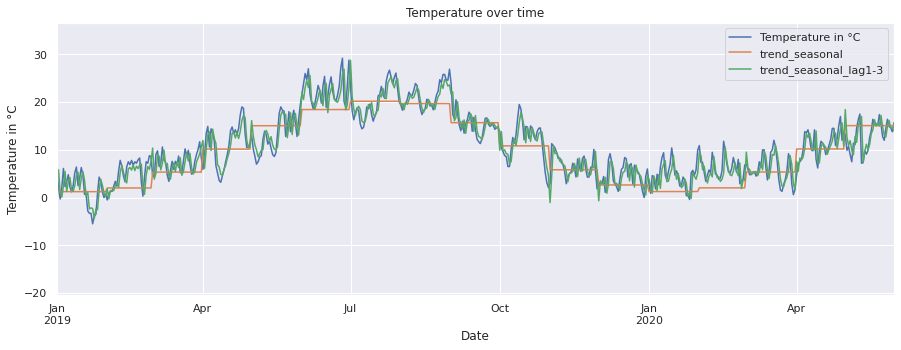

In [57]:
# plot
df_train_lag[['Temperature in °C','trend_seasonal', 'trend_seasonal_lag1-3']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_train_lag['Temperature in °C'].min()*1.1,df_train_lag['Temperature in °C'].max()*1.2])
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-05-31'))

In [58]:
pd.DataFrame(m_lag.coef_.reshape(1,15), columns=X_full.columns)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
0,0.000061,0.783308,4.105073,8.89136,13.751652,17.141815,18.910931,18.364181,14.394893,9.539013,4.562085,1.374453,0.924269,-0.205105,0.074323


---
---

## **8. Evaluate the model**
+ Cross validation on Time Series

In [59]:
X_full.head(1)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
1948-01-04,3,0,0,0,0,0,0,0,0,0,0,0,8.845059,4.745121,-1.454818


In [60]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [61]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [62]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_lag, X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.91373595, 0.91023894, 0.90570087, 0.91506874, 0.91978657])

In [63]:
result.mean()

0.9129062135667185

---
---

## **9. Test model**

### **9.1 Feature engineer the test data**

In [66]:
# Assign X_test
X_test = df_test.drop(columns=['Temperature in °C', 'year','month'])

In [68]:
df_test['trend_seasonal'] = m.predict(X_test)
df_test.head(1)

,Temperature in °C,year,month,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend_seasonal
Date,,,,,,,,,,,,,,,,
2020-06-01,17.0,2020,6,26450,0,0,0,0,1,0,0,0,0,0,0,18.464759


In [70]:
# Calculate the remainder for the test set
df_test['remainder'] = df_test['Temperature in °C'] - df_test['trend_seasonal']

In [71]:
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

In [72]:
X_test_full = df_test.drop(columns=['Temperature in °C', 'trend_seasonal', 'remainder', 'year', 'month'])

In [74]:
X_test_full.loc['2020-06-01', 'lag1'] = df_train.loc['2020-05-31', 'remainder']
X_test_full.loc['2020-06-01', 'lag2'] = df_train.loc['2020-05-30', 'remainder']
X_test_full.loc['2020-06-01', 'lag3'] = df_train.loc['2020-05-29', 'remainder']
X_test_full.loc['2020-06-02', 'lag2'] = df_train.loc['2020-05-31', 'remainder']
X_test_full.loc['2020-06-02', 'lag3'] = df_train.loc['2020-05-30', 'remainder']
X_test_full.loc['2020-06-03', 'lag3'] = df_train.loc['2020-05-31', 'remainder']

In [75]:
X_test_full.head()

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2020-06-01,26450,0,0,0,0,1,0,0,0,0,0,0,0.621853,-1.278086,-0.478025
2020-06-02,26451,0,0,0,0,1,0,0,0,0,0,0,-1.464759,0.621853,-1.278086
2020-06-03,26452,0,0,0,0,1,0,0,0,0,0,0,1.535180,-1.464759,0.621853
2020-06-04,26453,0,0,0,0,1,0,0,0,0,0,0,0.535118,1.535180,-1.464759
2020-06-05,26454,0,0,0,0,1,0,0,0,0,0,0,-0.064943,0.535118,1.535180


In [76]:
# Create the predictions
df_test['trend_seasonal_lag1-3'] = m_lag.predict(X_test_full)

In [78]:
df_full = df_train[['Temperature in °C', 'trend_seasonal', 'trend_seasonal_lag1-3']].append(df_test[['Temperature in °C', 'trend_seasonal', 'trend_seasonal_lag1-3']])

(18047.0, 18778.0)

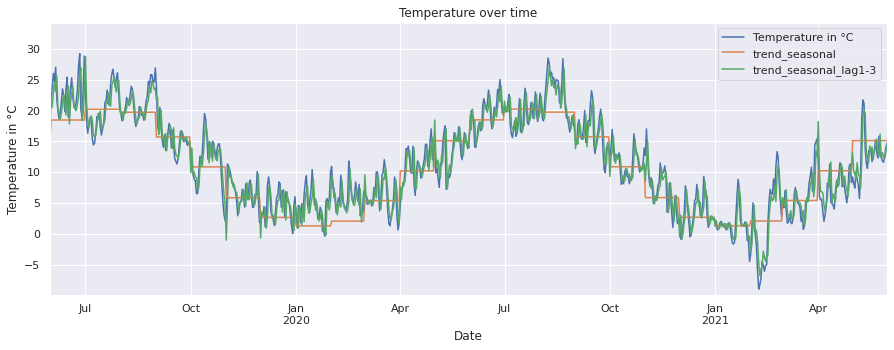

In [79]:
# plot
df_full[['Temperature in °C','trend_seasonal', 'trend_seasonal_lag1-3']].plot()
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.ylim([df_test['Temperature in °C'].min()*1.1,df_test['Temperature in °C'].max()*1.2])
plt.xlim(pd.Timestamp('2019-05-31'), pd.Timestamp('2021-05-31'))

In [80]:
print(f"""
{m_lag.score(X_test_full, df_test['Temperature in °C'])}
{m.score(X_test, df_test['Temperature in °C'])}
""")



0.9231943980908737
0.7693651506302399



---
---

## **10. Predict the future**

In [81]:
# Combine train and test data
df_complete = df_train.append(df_test)
X_complete = df_complete.drop(columns=['year','month','Temperature in °C','trend_seasonal', 'remainder','trend', 'trend_seasonal_lag1-3'])
X_complete.tail(4)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2021-05-28,26811,0,0,0,1,0,0,0,0,0,0,0,-3.300214,-2.700153,-2.500092
2021-05-29,26812,0,0,0,1,0,0,0,0,0,0,0,-3.500275,-3.300214,-2.700153
2021-05-30,26813,0,0,0,1,0,0,0,0,0,0,0,-2.600336,-3.500275,-3.300214
2021-05-31,26814,0,0,0,1,0,0,0,0,0,0,0,-1.200397,-2.600336,-3.500275


In [82]:
X_complete.loc['2020-06-01', 'lag1'] = df_train.loc['2020-05-31', 'remainder']
X_complete.loc['2020-06-01', 'lag2'] = df_train.loc['2020-05-30', 'remainder']
X_complete.loc['2020-06-01', 'lag3'] = df_train.loc['2020-05-29', 'remainder']
X_complete.loc['2020-06-02', 'lag2'] = df_train.loc['2020-05-31', 'remainder']
X_complete.loc['2020-06-02', 'lag3'] = df_train.loc['2020-05-30', 'remainder']
X_complete.loc['2020-06-03', 'lag3'] = df_train.loc['2020-05-31', 'remainder']

In [83]:
y_complete = df_complete['Temperature in °C']
y_complete

Date
1948-01-04    10.2
1948-01-05    10.5
1948-01-06     3.3
1948-01-07     2.9
1948-01-08     6.2
              ... 
2021-05-27    11.8
2021-05-28    11.6
2021-05-29    12.5
2021-05-30    13.9
2021-05-31    14.7
Name: Temperature in °C, Length: 26812, dtype: float64

In [84]:
m_complete = LinearRegression()
m_complete.fit(X_complete, y_complete)

LinearRegression()

In [85]:
X_complete.tail(1)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
Date,,,,,,,,,,,,,,,
2021-05-31,26814,0,0,0,1,0,0,0,0,0,0,0,-1.200397,-2.600336,-3.500275


### **10.1 first prediction t+1**

In [86]:
timestep = X_complete['timestep'].max() + 1
months= [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
lag1 = df_complete.loc['2021-05-31', 'remainder']
lag2 = df_complete.loc['2021-05-30', 'remainder']
lag3 = df_complete.loc['2021-05-29', 'remainder']

In [87]:
X_future = pd.DataFrame([[timestep] + months + [lag1] + [lag2] + [lag3]])
X_future.columns = X_complete.columns

In [88]:
X_future

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
0,26815,0,0,0,0,1,0,0,0,0,0,0,-0.400458,-1.200397,-2.600336


In [89]:
# Prediction for 2021-06-01
y_future = m_complete.predict(X_future)
y_future

array([18.15057621])

### **10.2 second prediction t+2**

In [90]:
timestep = X_complete['timestep'].max() + 2
months= [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
lag1 = 0
lag2 = df_complete.loc['2021-05-31', 'remainder']
lag3 = df_complete.loc['2021-05-30', 'remainder']

In [91]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag1] + [lag2] + [lag3]  ])
X_future_2.columns = X_complete.columns
X_future_2

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag1,lag2,lag3
0,26816,0,0,0,0,1,0,0,0,0,0,0,0,-0.400458,-1.200397


In [92]:
# Prediction for 2021-06-02
y_future_2 = m_complete.predict(X_future_2)
y_future_2

array([18.45950307])

---
---

## **11. Compare the statistical output of different AR models**

### **11.1 ARIMA model**

##### 11.1.1 First step: Look at AR model

In [93]:
selected_order = ar_select_order(df_rem['remainder'], maxlag = 12, old_names=False)
selected_order.ar_lags

/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3])

---

### 11.1.2 Now we add the Moving Average part to get make use of the ARIMA model

### including a Moving Average part (MA)
+ uncluding 3 lags (p=3)
+ no further differenciation needed (d=0)
+ the autoregression plot of the remainder doesnt cut off. So we use either a pure AR model or ARIMA model (q=0 or q>0)

Additional Observation: A pure MA model is not recommended since we dont experience a harsh drop in the autoregression plot

In [94]:
pm.acf(df_rem['remainder'])

/home/marcel/anaconda3/lib/python3.8/site-packages/pmdarima/utils/wrapped.py:59: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  return sm_acf(x=x, unbiased=unbiased, nlags=nlags,


array([1.        , 0.80365194, 0.5972008 , 0.46135866, 0.36998598,
       0.29985187, 0.24523175, 0.20205481, 0.16748128, 0.13848446,
       0.11269598, 0.08650211, 0.06603988, 0.05183671, 0.04051665,
       0.03253237, 0.02644261, 0.02684548, 0.02982885, 0.03195668,
       0.03312316, 0.03795421, 0.04158966, 0.043558  , 0.04485579,
       0.04743962, 0.05273058, 0.05633107, 0.0605524 , 0.06784972,
       0.077063  , 0.0779716 , 0.06904582, 0.05998331, 0.05139152,
       0.04618244, 0.04070682, 0.03813587, 0.03566184, 0.03508374,
       0.03254579])

/home/marcel/anaconda3/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


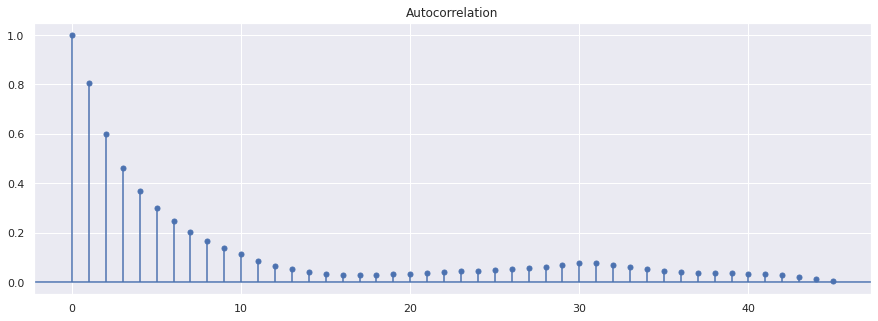

In [95]:
pm.plot_acf(df_rem['remainder'])

In [122]:
stepwise_fit = pm.auto_arima(df_rem['remainder'], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=4,
                             start_P=0, seasonal=True,
                             d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=119442.263, Time=9.76 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=147504.033, Time=0.64 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=120040.623, Time=5.84 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=126929.357, Time=8.55 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=147502.033, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=119458.131, Time=4.59 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=119438.858, Time=28.23 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=119441.594, Time=13.53 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=119438.715, Time=49.09 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=119436.729, Time=26.16 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=126485.567, Time=56.40 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=120042.002, Time=15.42 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=119421.698, Time=35.55 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=119425.237, Time=21.46 s

#### best model is identified as ARIMA (3,0,1)

In [97]:
stepwise_fit.summary()

NameError: name 'stepwise_fit' is not defined

In [104]:
# Fit an ARIMA model 
arima_model = ARIMA(df_rem['remainder'], order=(3,0,1)).fit() # order is (p,d,q) or (ar,i,ma)

/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/marcel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Date
1948-01-04    10.544998
1948-01-05    10.844937
1948-01-06     3.644876
1948-01-07     3.244815
1948-01-08     6.544754
                ...    
2020-05-27     1.322098
2020-05-28    -0.177963
2020-05-29    -0.478025
2020-05-30    -1.278086
2020-05-31     0.621853
Name: remainder, Length: 26447, dtype: float64

In [99]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                26447
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -59686.686
Date:                Fri, 25 Jun 2021   AIC                         119385.373
Time:                        11:41:25   BIC                         119434.470
Sample:                    01-04-1948   HQIC                        119401.221
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.071      0.075      0.940      -0.135       0.145
ar.L1          1.2153      0.071     17.135      0.000       1.076       1.354
ar.L2         -0.4707      0.064     -7.362      0.000      -0.596      -0.345
ar.L3          0.1137      0.010     11.370      0.000       0.094       0.133
ma.L1         -0.2927      0.071     -4.103      0.000      -0.432      -0.153
sigma2         5.3429      0.041    130.406      0.000       5.263       5.423
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.99
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[]

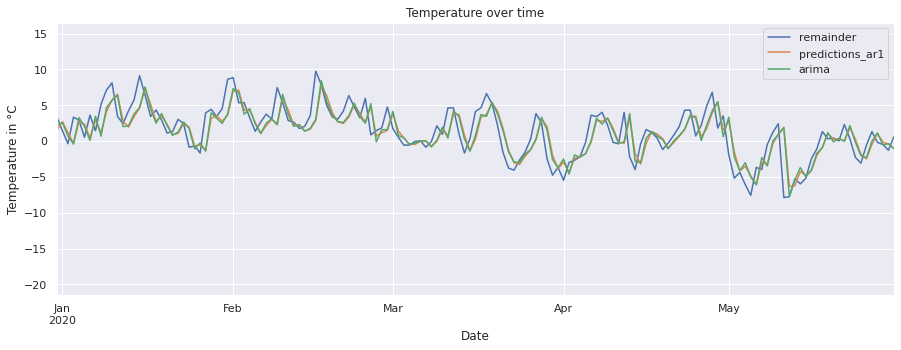

In [123]:
# plot
df_rem[['remainder', 'predictions_ar1']].plot()
plt.plot(arima_model.predict(), label='arima')
plt.title("Temperature over time")
plt.ylabel('Temperature in °C')
plt.xlim(pd.Timestamp('2019-12-31'), pd.Timestamp('2020-05-31'))
plt.legend()
plt.plot()

### Observation: The Moving Average term improved the model just slightly

---

## **12. Test the remainder for stationarity**
+ Augmented Dicker-Fuller Test

In [ ]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=1; CI=99%) 
            {round(levels['5%'],2)} (p=5; CI=95%)
            {round(levels['10%'],2)} (p=10 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [ ]:
print_adf(df_complete['remainder'])

### Observation: The remainder is to 99% stationary

---

## **13. Create a Map for Germany (Berlin)**

In [129]:
df_map = df_clean

In [139]:
df_map= df_map[['Temperature in °C', 'year', 'month']]

In [146]:
df_map['country'] = 'Germany'

In [148]:
df_map.head(3)

,Temperature in °C,year,month,country
Date,,,,
1948-01-01,-1.8,1948,1,Germany
1948-01-02,4.4,1948,1,Germany
1948-01-03,8.5,1948,1,Germany


In [142]:
SHAPEFILE = 'Data/ne_110m_admin_0_countries.shp'

In [179]:
#Read in the shapefile with geopandas
import geopandas as gpd
gdf = gpd.read_file(SHAPEFILE)[['ADMIN', 'geometry']]
gdf.columns = ['country', 'geometry']

In [180]:
df_map = df_map.groupby(['country', 'year'])[['Temperature in °C']].mean().reset_index()

In [181]:
gdf = pd.merge(left=gdf, right=df_map, how='left', on='country')

In [182]:
gdf.loc[gdf['country'] == 'Germany']

,country,geometry,year,Temperature in °C
121,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1948.0,10.296175
122,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1949.0,10.474521
123,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1950.0,9.768493
124,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1951.0,10.187945
125,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1952.0,9.010656
...,...,...,...,...
190,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",2017.0,10.712055
191,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",2018.0,11.755616
192,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",2019.0,11.824384
193,Germany,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",2020.0,11.728415


In [226]:
basemap = folium.Map(location=[52.54, 13.36],
                zoom_start=6,
                tiles='CartoDB positron') #try out the other options!

In [249]:
for i in range(1948,2021):
    gdf_map = gdf[gdf['year'] == i]
    json_map = gdf_map.to_json()
    
    basemap = folium.Map(location=[52.54, 13.36],
                zoom_start=5,
                tiles='CartoDB positron') #try out the other options!
    yeartag = 'Year {}'.format(i)
    tiles = folium.Choropleth(
            geo_data=json_map,                 # geojson string that includes the geo data (for the year 2000)
            name="{i} Data",
            data=gdf_map,                      # dataframe that includes the data (for the year 2000)
            columns=["country", "Temperature in °C"], # names of the columns to include from the dataframe
            key_on="properties.country",        # name of JSON key within the "properties" value that contains country names
            fill_color="OrRd",                # play around with the rest of the aesthetic options
            nan_fill_color="black",         
            fill_opacity=0.5,
            line_opacity=0.2,
            threshold_scale=[7.0,8.0,9.0,10.0,11.0,12.0],
            legend_name=yeartag,
            highlight=True,
        )
    tiles.add_to(basemap) #add the layer to the blank canvas / figure
    
    style_html = "font-size: 10px; font-weight: small" #add a little bit of HTML, if you know some.
    tooltip = folium.features.GeoJsonTooltip(fields = ['Temperature in °C'],
                                         style = style_html) 
    tiles.geojson.add_child(tooltip)
    nametag = 'maps/{}_map.png'.format(i)
    basemap.save('map.html')
    

    driver = selenium.webdriver.Chrome('Data/chromedriver')  # Optional argument, if not specified will search path.

    #driver.get('http://www.google.com/');
    driver.set_window_size(4000, 3000)  # choose a resolution
    driver.get('file:///home/marcel/Documents/SpicedProjects/sumac-sample-student-code/week_7/map.html')
    time.sleep(1)
    driver.save_screenshot(nametag)
    driver.quit();
    #img_data = basemap._to_png(5)
    #img = Image.open(io.BytesIO(img_data))
    #img.save('nametag')

In [252]:
images = []

for i in range(1948,2021):
    filename = 'maps/{}_map.png'.format(i)
    images.append(imageio.imread(filename))

imageio.mimsave('maps/Animated_map.gif', images, fps=2)

---
---